In [1]:
%matplotlib inline
from tools import *

# Ch04 数据表示与特征工程

-   连续特征 ( Continuous Feature ) 。
-   分类特征 ( Categorical Feature ) ，也叫离散特征 ( Discrete Feature ) 。

特征工程：找到最佳的数据表示。

虽然神经网络已经可以自动完成特征的选择和变换，但是深入学习特征变换的原理，可以帮助理解神经网络对数据进行了哪种变化，从而加深对数据的理解，能够更加显式地操纵数据变换过程，提高数据变换的效率和加入更多的先验信息。

## 4.5 自动化特征选择

三种基本的策略：

-   单变量统计 ( Univariate Statistics ) ：计算每个特征和目标值之间的关系是否存在统计显著性，
然后选择置信度最高的特征。
    -   分类问题：叫做方差分析 ( Analysis of Variance, ANOVA ) ，只单独考虑每个特征。
    -   优点：计算速度快，不需要构建模型；完全独立于应用的模型
    -   删除噪声特征可以提高精确度，即使删除了部分原始特征，也不会影响模型的精确度。
    说明某些特征是有相关性的，删除部分特征后可以减少噪声的干扰。
-   基于模型的选择 ( Model-Based Selection ) ：使用一个监督机器学习模型来判断每个特征的重要性，
并且仅保留最重要的特征。
    -   特征选择模型不需要跟特征训练模型相同；
    -   特征选择模型需要提供特征的重要性度量，从而可以使用度量排序；
    -   特征选择模型同时考虑所有特征，可以获取交互项
    -   常用的特征选择模型：
        -   基于决策树的模型提供的 feature_importances_，可以直接编码每个特征的重要性
        -   线性模型系数的绝对值
-   迭代选择 ( Iterative Selection )
    -   两种迭代特征选择方法
        -   开始没有特征，逐渐增加特征，直到满足某个终止条件
        -   开始所有特征，逐渐删除特征，直到满足某个终止条件

特征选择总结：如果选择了正确的特征，线性模型的表现就能够与随机森林一样好。

### 4.5.1. 单变量统计（计算每个特征和目标值之间的关系是否存在统计显著性，然后选择最高置信度的特征）

-   对于分类问题，也称为方差分析；关键性质是单变量的，即只单独考虑每个特征
-   计算速度快，不需要构建模型；完全独立于特征选择之后的应用模型

NOTE: 在这个数据上，这种选择特征的方式最好，尽可能选择了原始特征，而不是噪声特征

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

# get deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
# add noise features to the data
# the first 30 features are from the dataset, the next 50 are noise
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(
    X_w_noise, cancer.target, random_state=0, test_size=.5)
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


[ True  True  True  True  True  True  True  True  True False  True False  True  True  True  True  True  True False False  True  True  True  True  True  True  True  True  True  True False False False
  True False  True False False  True False False False False  True False False  True False False  True False  True False False False False False False  True False  True False False False False  True
 False  True False False False False  True  True False  True False False False False]


([], [])

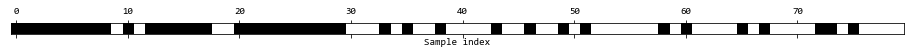

In [3]:
mask = select.get_support()
print(mask)
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

In [4]:
from sklearn.linear_model import LogisticRegression

# transform test data
X_test_selected = select.transform(X_test)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print("Score with all features: {:.3f}".format(lr.score(X_test, y_test)))
lr.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(lr.score(X_test_selected, y_test)))

Score with all features: 0.940
Score with only selected features: 0.940


### 4.5.2. 基于模型的特征选择
（使用监督机器学习模型来判断每个特征的重要性，仅保留最重要的特征）

In [5]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")

In [6]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


([], [])

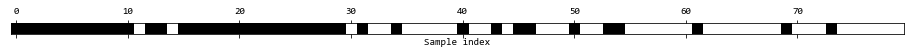

In [7]:
mask = select.get_support()
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

In [8]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression(max_iter=1000).fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.954


### 4.5.3. 迭代特征选择：构建一系列模型，每个模型都使用不同数量的特征
递归特征消除（Recursive Feature Elimination，RFE）：从所有特征开始构建模型，根据模型舍弃最不重要的特征，直到满足某个终止条件。

注：速度较慢，效果一般。

([], [])

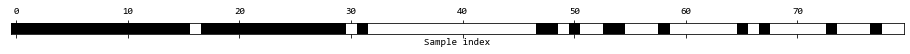

In [9]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=40)

select.fit(X_train, y_train)
# visualize the selected features:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

In [10]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = LogisticRegression(max_iter=1000).fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.951


In [11]:
print("Test score: {:.3f}".format(select.score(X_test, y_test)))

Test score: 0.951
